![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 12 - RNN Architectures </center>
### <center> Sequence to Sequence (Machine Translation) </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/12_RNN_Architectures/MainTranslation.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [11]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

import torch
import torch.nn          as nn
import torch.optim       as optim
import torchtext

from torchtext.vocab import Vocab

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
DEVICE

device(type='cuda', index=0)

In [12]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/12_RNN/DeepLearningFramework ./DeepLearningFramework

### Load the data:

In [13]:
import re

def NormalizeEnglish(line):
    line = line.lower().strip()
    line = re.sub(r"([.!?])", r" \1",     line) #-- add space before [.!?]
    line = re.sub(r"[^a-zA-Z.!?]+", r" ", line) #-- keep only letters and [.!?]
    return line

def NormalizeHebrew(line):
    line = line.strip()
    line = re.sub(r"([.!?])", r" \1", line)
    line = re.sub(r"[^\u0590-\u05fe.!?]+", r" ", line)
    return line

dirPath = '../../data/Translation//'
lLines  = []
with open(dirPath + 'heb.txt', encoding='utf-8') as oFile:
    for line in oFile:
        lSplit  = line.split('\t')[:2]
        lLines += [(NormalizeEnglish(lSplit[0]), NormalizeHebrew(lSplit[1]))]

lLines[26600:26605], len(lLines)

([('tom found evidence .', 'תום מצא ראיות .'),
  ('tom freed the bird .', 'טום שחרר את הציפור .'),
  ('tom freed the bird .', 'טום שלח את הציפור לחופשי .'),
  ('tom gasped for air .', 'תום נאבק לנשום .'),
  ('tom gets headaches .', 'תום מקבל כאבי ראש .')],
 126692)

#### Keep only short sentences:

In [14]:
mData = np.array(lLines, dtype=np.object_)
mData.shape

(126692, 2)

In [15]:
MAX_LENGTH  = 6
LineLength  = np.vectorize(lambda line: len(line.split()))
vLineLength = LineLength(mData[:,0])
mData       = mData[vLineLength<6,:]
N           = mData.shape[0]
N

38143

#### Build vocabularies:

In [16]:
from torchtext.vocab import build_vocab_from_iterator

def YieldTokens(lLines):
    for line in lLines:
        yield line.split()

def MakeVocab(lLines):
    oVocab = build_vocab_from_iterator(YieldTokens(lLines), min_freq=2, specials=('<UNK>', '<SOS>', '<EOS>', '<PAD>'))
    oVocab.set_default_index(oVocab['<UNK>'])
    return oVocab

lEnglish  = mData[:,0]
lHebrew   = mData[:,1]
oEngVocab = MakeVocab(lEnglish)
oHebVocab = MakeVocab(lHebrew)

len(oEngVocab), len(oHebVocab)

(4769, 8139)

#### Line2Tensor:

In [17]:
def Line2Tensor(oVocab, line):
    return torch.tensor([oVocab['<SOS>']] + [oVocab[w] for w in line.split()] + [oVocab['<EOS>']])

def Tensor2Line(oVocab, vLine):
    return ' '.join([oVocab.get_itos()[e] for e in vLine])
    
#-- Test:
eng1 = lEnglish[15002]
heb1 = lHebrew [15002]
eng2 = Line2Tensor(oEngVocab, eng1)
heb2 = Line2Tensor(oHebVocab, heb1)
eng3 = Tensor2Line(oEngVocab, eng2)
heb3 = Tensor2Line(oHebVocab, heb2)

print(f'Origianl (Eng) - {eng1}')
print(f'Origianl (Heb) - {heb1}')
print(f'Tensor   (Eng) - {eng2}')
print(f'Tensor   (Heb) - {heb2}')
print(f'Back     (Eng) - {eng3}')
print(f'Back     (Heb) - {heb3}')

Origianl (Eng) - do it again tom .
Origianl (Heb) - עוד הפעם תום .
Tensor   (Eng) - tensor([  1,  34,  10, 101,   5,   4,   2])
Tensor   (Heb) - tensor([   1,  118, 3409,    5,    4,    2])
Back     (Eng) - <SOS> do it again tom . <EOS>
Back     (Heb) - <SOS> עוד הפעם תום . <EOS>


#### Dataset:

In [18]:
class LangDataset(torch.utils.data.Dataset):
    def __init__(self, lSrc, lTrg, oSrcVocab, oTrgVocab, DEVICE):
        self.lSrc      = lSrc
        self.lTrg      = lTrg
        self.oSrcVocab = oSrcVocab
        self.oTrgVocab = oTrgVocab
        
    def __len__(self):
        return len(self.lSrc)
    
    def __getitem__(self, idx):
        sSrc = self.lSrc[idx]
        sTrg = self.lTrg[idx]
        
        vSrc = Line2Tensor(self.oSrcVocab, sSrc).to(DEVICE)
        vTrg = Line2Tensor(self.oTrgVocab, sTrg).to(DEVICE)

        return vSrc, vTrg
    
oDataset           = LangDataset(lEnglish, lHebrew, oEngVocab, oHebVocab, DEVICE)
vEngLine, vHebLine = oDataset[15005]

Tensor2Line(oEngVocab, vEngLine), Tensor2Line(oHebVocab, vHebLine)

('<SOS> do what is right . <EOS>', '<SOS> תעשה את הדבר הנכון . <EOS>')

In [19]:
from torch.utils.data import random_split

nTrain              = 30000
nTest               = N - nTrain
oTrainSet, oTestSet = random_split(oDataset, [nTrain, nTest])

len(oTrainSet), len(oTestSet)

(30000, 8143)

In [20]:
from torch.utils.data   import DataLoader
from torch.nn.utils.rnn import pack_sequence
from torch.nn.utils.rnn import pad_sequence

oSrcVocab = oEngVocab
oTrgVocab = oHebVocab
def LangCollateFunction(lBatch):
    lSrc, lTrg = zip(*lBatch)
    mTrg       = pad_sequence(lTrg, padding_value=oTrgVocab['<PAD>'], batch_first=True)
    
    return (lSrc, mTrg)

batchSize = 64
oTrainDL  = DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   collate_fn=LangCollateFunction)
oTestDL   = DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, collate_fn=LangCollateFunction)

lSrc, mTrg = next(iter(oTrainDL))
len(lSrc), lSrc[0].shape, mTrg.shape

(64, torch.Size([6]), torch.Size([64, 8]))

#### Encoder RNN:
<img src="https://github.com/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/12_RNN_Architectures/RnnEncoder.png?raw=true" style="width: 700px;"/>
We can also make a bidirectional encoder.

In [22]:
from torch.nn.utils.rnn import pack_sequence, PackedSequence

def PackedAs(mData, mPack):
    return PackedSequence(mData, mPack.batch_sizes, mPack.sorted_indices, mPack.unsorted_indices)

class EncoderRNN(nn.Module):
    def __init__(self, V, D, H, L):
        super(EncoderRNN, self).__init__()
        self.oEmbedding = nn.Embedding(V, D, padding_idx=oEngVocab['<PAD>'])
        self.oGRU       = nn.GRU      (D, H, L, bidirectional=True)
        
    def forward(self, lSrc):
        #-- len(lSrc)     = N
        #-- lSrc[0].shape = (Ti,)
        mPackSrc = pack_sequence(lSrc, enforce_sorted=False)    #-- mPackSrc.shape = (N*T,)
        mE       = self.oEmbedding(mPackSrc.data)               #-- mE    .shape = (N*T, D)
        mPackE   = PackedAs       (mE, mPackSrc)                #-- mPackE.shape = (N*T, D)
        _, mH    = self.oGRU      (mPackE)                      #-- mH    .shape = (2*L, N, H)
        mC       = torch.cat      ([mH[[-1]], mH[[-2]]], dim=2) #-- mC    .shape = (1,   N, 2*H)

        return mC
#-------------------------------------------------------------------------------------------------------#
#-------------------------------------------------------------------------------------------------------#
V = len(oEngVocab)
D = 64
H = 32
L = 2
EncoderRNN(V, D, H, L).to(DEVICE)(lSrc).shape

torch.Size([1, 64, 64])

#### Decoder RNN:
<img src="https://github.com/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/12_RNN_Architectures/RnnDocoder.png?raw=true" style="width: 700px;"/>

In [25]:
class DecoderRNN(nn.Module):
    def __init__(self, V, D, H):
        super(DecoderRNN, self).__init__()
        self.oEmbedding = nn.Embedding(V, D)
        self.oGRU       = nn.GRU   (D + H,   H)
        self.oFC        = nn.Linear(D + 2*H, V)
        
    def forward(self, vTrg, mC, mS):
        #-- vTrg.shape = (N,)
        #-- mC  .shape = (1, N, H)
        #-- mS  .shape = (1, N, H)
        mE     = self.oEmbedding(vTrg)[None,:,:]  #-- mE   .shape = (1, N, D)
        mEC    = torch.cat      ([mE, mC], dim=2) #-- mEC  .shape = (1, N, D+H)
        _, mS  = self.oGRU      (mEC, mS)         #-- mS   .shape = (1, N, H)
        
        mCat   = torch.cat([mC[0], mS[-1], mE[0]], dim=1) #-- mCat.shape = (N, D+2*H)
        mZ     = self.oFC (mCat)                          #-- mZ   .shape = (N, V)
        return mZ, mS
    
V      = len(oHebVocab)
D      = 64
H      = 32
mS     = torch.randn(1, batchSize, H).to(DEVICE)
mC     = torch.randn(1, batchSize, H).to(DEVICE)
vTrg   = mTrg[:,0]
mZ, mS = DecoderRNN(V, D, H).to(DEVICE)(vTrg, mC, mS)

mZ.shape, mS.shape

(torch.Size([64, 8139]), torch.Size([1, 64, 32]))

#### Full Model:

In [42]:
Vsrc = len(oSrcVocab)
Vtrg = len(oTrgVocab)
class Seq2Seq(nn.Module):
    def __init__(self):
        super(Seq2Seq, self).__init__()
        
        D             = 256                         #-- D = Embedding
        H             = 512                         #-- H = Hidden state
        self.oEncoder = EncoderRNN(Vsrc, D, 1*H, 1)
        self.oDecoder = DecoderRNN(Vtrg, D, 2*H)

    def forward(self, lSrc, mTrg, pTeacher=0):
        #-- len(lSrc)  = N
        #-- mTrg.shape = (N, T) or None
        N, T     = mTrg.shape
        DEVICE   = mTrg.device                                                          #-- CPU\GPU
        vTrgIn   = oTrgVocab['<SOS>'] * torch.ones(N, dtype=torch.int32, device=DEVICE) #-- vTrgIn .shape = (N,)
        mLogits  = torch.zeros((N, Vtrg, T-1),                           device=DEVICE) #-- mLogits.shape = (N, V, T)
        bTeacher = torch.rand(1) < pTeacher
        
        #-- Enocde:
        mC = self.oEncoder(lSrc) #-- mC.shape = (1, N, H)
        mH = mC
        
        for ii in range(T - 1):
            #-- Decode:
            mZ, mH          = self.oDecoder(vTrgIn, mC, mH)
            mLogits[:,:,ii] = mZ
           
            #-- Next input (train \ test):
            if bTeacher == True:
                vTrgIn = mTrg[:,ii+1] #-- vHebIn.shape(N)
            else:
                vTrgIn = mZ.argmax(dim=1)

        return mLogits
        
mWordOut = Seq2Seq().to(DEVICE)(lSrc, mTrg, 0.5)
mWordOut.shape

torch.Size([64, 8139, 7])

In [43]:
# from torch.distributions.categorical import Categorical

# Vsrc = len(oSrcVocab)
# Vtrg = len(oTrgVocab)
# D    = 256  #-- D = Embedding
# H    = 512  #-- H = Hidden state
#             #-- T = Sequence length
    
# class Seq2Seq(nn.Module):
#     def __init__(self):
#         super(Seq2Seq, self).__init__()
#         self.oEncoder   = EncoderRNN(Vsrc, D, 1*H, 1)
#         self.oDecoder   = DecoderRNN(Vtrg, D, 2*H)

#     def forward(self, lSrc, mTrg=None, pTeacher=0, bTop1=False):

#         N      = len(lSrc)
#         device = lSrc[0].device
#         if mTrg is None:
#             T      = 256
#             vTrgIn = oTrgVocab['<SOS>'] * torch.ones(N, dtype=torch.int32, device=device)
#         else:
#             T      = mTrg.shape[1]                              #-- mTrg      .shape = (N, T)
#             vTrgIn = mTrg[:,0]                                  #-- vTrgIn .shape = (N,)
#         mLogitsOut = torch.zeros((N, T-1, Vtrg), device=device) #-- mLogitsOut.shape = (N, T, V)
#         mTrgOut    = torch.zeros((N, T-1),       device=device) #-- mTrgOut   .shape = (N, T)

#         mC     = self.oEncoder(lSrc)                            #-- mC        .shape = (1, N, H)
#         mH     = mC
        
#         for ii in range(T - 1):
#             #-- Decode:
#             mZ, mH             = self.oDecoder(vTrgIn, mC, mH)
#             mLogitsOut[:,ii,:] = mZ
           
#             #-- Next input (train \ test):
#             if torch.rand(1) < pTeacher:
#                 vTrgIn = mTrg[:,ii+1] #-- vHebIn.shape(N)
#             else:
#                 if bTop1 == True:
#                     vTrgIn = mZ.argmax(dim=1)
#                 else:
#                     vTrgIn = Categorical(logits=mZ).sample()
            
#             mTrgOut[:,ii] = vTrgIn
            
#         #-- Keep sequences up to <EOS>:
#         vIdx    = (mTrgOut == oTrgVocab['<EOS>']).int().argmax(dim=1)
#         lTrgOut = [mTrgOut[ii,:vIdx[ii]] for ii in range(N)]
#         return mLogitsOut, lTrgOut
        
# mWordOut = Seq2Seq()(lSrc, mTrg, 0.5, True)[0]
# mWordOut.shape

In [44]:
def Epoch(oModel, oDataDL, Loss, Metric, oOptim=None, oScheduler=None, bTrain=True):

    epochLoss   = 0
    epochMetric = 0
    count       = 0
    nIter       = len(oDataDL)
    vLR         = np.full(nIter, np.nan)
    DEVICE      = next(oModel.parameters()).device #-- CPU\GPU


    oModel.train(bTrain) #-- train or test

    #-- Iterate over the mini-batches:
    for ii, (lSrc, mY) in enumerate(oDataDL):
        #-- Data is already on DEVICE
        #-- Forward:
        if bTrain == True:
            #-- Store computational graph:
            mOut = oModel(lSrc, mY, pTeacher=0.5)
            loss = Loss(mOut, mY[:,1:]) #-- omit <SOS>
        else:
            with torch.no_grad():
                #-- Do not store computational graph:
                mOut = oModel(lSrc, mY, pTeacher=0)
                loss = Loss(mOut, mY[:,1:]) #-- omit <SOS>

        #-- Backward:
        if bTrain == True:
            oOptim.zero_grad() #-- set gradients to zeros
            loss.backward()    #-- backward
            oOptim.step()      #-- update parameters
            if oScheduler is not None:
                vLR[ii] = oScheduler.get_last_lr()[0]
                oScheduler.step() #-- update learning rate

        with torch.no_grad():
            Nb           = mY.shape[0]
            count       += Nb
            epochLoss   += Nb * loss.item()
            epochMetric += Nb * Metric(mOut, mY[:,1:])
        print(f'\r{"Train" if bTrain else "Val"} - Iteration: {ii:3d} ({nIter}): loss = {loss:2.6f}', end='')

    print('', end='\r')
    epochLoss   /= count
    epochMetric /= count

    return epochLoss, epochMetric, vLR

In [45]:
from torch.optim.lr_scheduler       import OneCycleLR
from DeepLearningFramework.Training import TrainModel
from DeepLearningFramework.Metric   import Accuracy

Loss   = nn.CrossEntropyLoss(ignore_index=oTrgVocab['<PAD>'])
Metric = Accuracy           (ignoreIndex =oTrgVocab['<PAD>'])

In [46]:
nEpochs    = 100
nIter      = nEpochs * len(oTrainDL)

oModel     = Seq2Seq    ().to(DEVICE)
oOptim     = optim.AdamW(oModel.parameters(), lr=1e-5, betas=(0.9, 0.99), weight_decay=5e-1)
oScheduler = OneCycleLR (oOptim, max_lr=5e-4, total_steps=nIter)
lHistory   = TrainModel (oModel, oTrainDL, oTestDL, Loss, Metric, nEpochs, oOptim, oScheduler, Epoch=Epoch, sModelName='Seq2Seq')

------------------------------------------------------------------------------------------------------------------------
Epoch 000: | Train loss:  5.119 | Val loss:  4.346 | Train Metric:  0.317 | Val Metric:  0.343 | epoch time: 17.295 | <-- Checkpoint!
Epoch 001: | Train loss:  4.020 | Val loss:  4.023 | Train Metric:  0.440 | Val Metric:  0.421 | epoch time: 15.323 | <-- Checkpoint!
Epoch 002: | Train loss:  3.702 | Val loss:  3.824 | Train Metric:  0.480 | Val Metric:  0.448 | epoch time: 13.124 | <-- Checkpoint!
Epoch 003: | Train loss:  3.480 | Val loss:  3.663 | Train Metric:  0.497 | Val Metric:  0.463 | epoch time: 13.692 | <-- Checkpoint!
Epoch 004: | Train loss:  3.259 | Val loss:  3.500 | Train Metric:  0.514 | Val Metric:  0.472 | epoch time: 13.489 | <-- Checkpoint!
Epoch 005: | Train loss:  3.039 | Val loss:  3.310 | Train Metric:  0.529 | Val Metric:  0.498 | epoch time: 13.033 | <-- Checkpoint!
Epoch 006: | Train loss:  2.814 | Val loss:  3.160 | Train Metric:  0.545 |

Epoch 059: | Train loss:  0.358 | Val loss:  2.357 | Train Metric:  0.903 | Val Metric:  0.602 | epoch time: 13.104 | <-- Checkpoint!
------------------------------------------------------------------------------------------------------------------------
Epoch 060: | Train loss:  0.355 | Val loss:  2.365 | Train Metric:  0.902 | Val Metric:  0.600 | epoch time: 13.203 |
Epoch 061: | Train loss:  0.349 | Val loss:  2.361 | Train Metric:  0.902 | Val Metric:  0.604 | epoch time: 13.133 | <-- Checkpoint!
Epoch 062: | Train loss:  0.343 | Val loss:  2.351 | Train Metric:  0.904 | Val Metric:  0.602 | epoch time: 13.062 |
Epoch 063: | Train loss:  0.337 | Val loss:  2.329 | Train Metric:  0.904 | Val Metric:  0.605 | epoch time: 13.417 | <-- Checkpoint!
Epoch 064: | Train loss:  0.325 | Val loss:  2.354 | Train Metric:  0.906 | Val Metric:  0.603 | epoch time: 13.191 |
Epoch 065: | Train loss:  0.319 | Val loss:  2.342 | Train Metric:  0.907 | Val Metric:  0.605 | epoch time: 13.135 |
Epoch

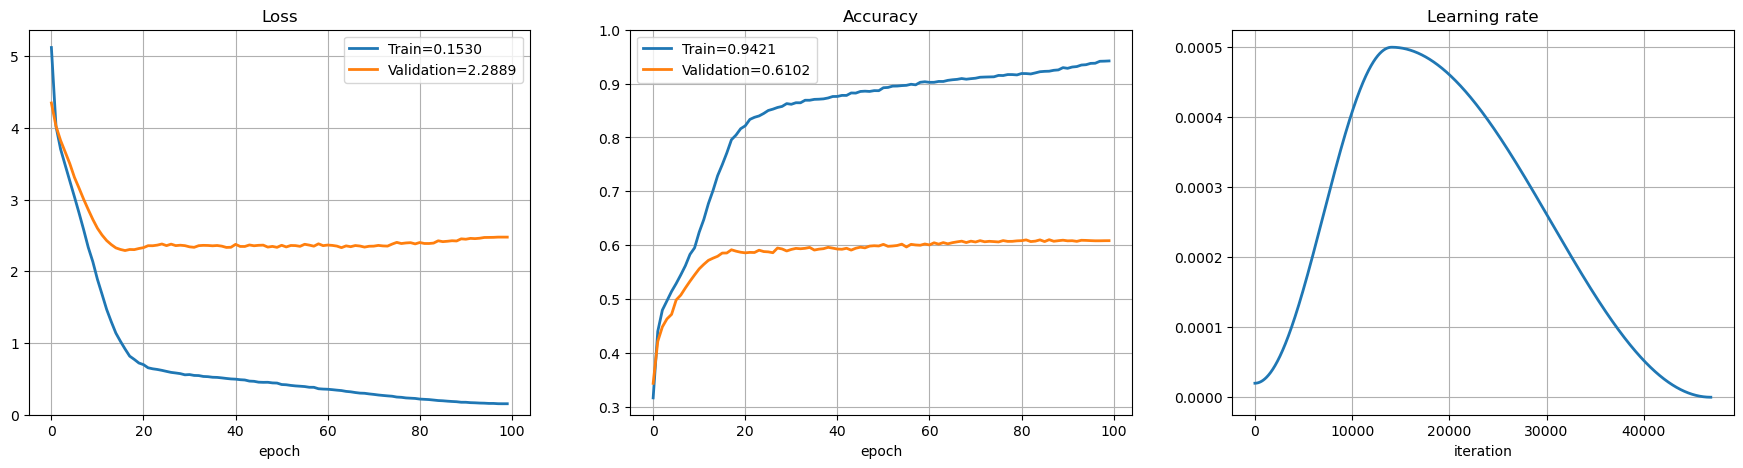

In [48]:
from DeepLearningFramework.Auxiliary import PlotHistory

PlotHistory(lHistory)
plt.show   ()

### Exercise (predict implementation)
Complete the `Predict` function implementation.  

Note: A [beam search](https://en.wikipedia.org/wiki/Beam_search) should be used instead of top 1 method.

In [53]:
from torch.distributions.categorical import Categorical

Categorical(logits=torch.randn(3,4)).sample()

tensor([2, 0, 3])

In [60]:
from torch.distributions.categorical import Categorical
    
def Predict(oModel, lSrc, bTop1=False):
    MAX_LENGTH = 256
    N          = len(lSrc)
    DEVICE     = lSrc[0].device
    vTrgIn     = ???
    mTrgOut    = torch.zeros((N, MAX_LENGTH), device=DEVICE) #-- mTrgOut.shape = (N, T)
    
    #-- Enocde:
    mC = ???
    mH = ???

    for ii in range(MAX_LENGTH):
        #-- Decode:
        mZ, mH = ???
        
        if bTop1 == True:
            vTrgIn = ???
        else:
            vTrgIn = ???

        mTrgOut[:,ii] = vTrgIn

    #-- Keep sequences up to <EOS>:
    vIdx    = (mTrgOut == oTrgVocab['<EOS>']).int().argmax(dim=1)
    lTrgOut = [mTrgOut[ii,:vIdx[ii]] for ii in range(N)]
    
    return lTrgOut

In [62]:
import pandas as pd

dLang = pd.DataFrame(index=range(10), columns=['English', 'GT (Hebrew)', 'Generated'])

for ii in range(10):
    idx        = np.random.randint(nTest)
    vEng, vHeb = oTestSet[idx]
    lEng       = [vEng.to(DEVICE)]
    with torch.no_grad():
        vHebOut = Predict(oModel, lEng)[0].int()

    dLang.iloc[ii,:] = [Tensor2Line(oEngVocab, vEng[1:-1]), Tensor2Line(oHebVocab, vHeb[1:-1]), Tensor2Line(oHebVocab, vHebOut)]

dLang

,English,GT (Hebrew),Generated
0,they must be americans .,הם כנראה אמריקנים .,הם צריך אמריקנים .
1,i feel better today .,היום אני מרגיש יותר טוב .,אני מרגישה יותר טוב יותר .
2,go on .,תמשיכו .,תמשיכי .
3,focus on your breathing .,<UNK> בנשימתך .,<UNK> בנשימתך .
4,we hit it off .,התיידדנו .,דגים את זה .
5,i need a crew .,אני צריך צוות .,אני צריך תביאי .
6,the mystery remains unsolved .,התעלומה נשארת בלתי פתורה .,<UNK> <UNK> בלתי לזוז .
7,he saw her video .,ראיתי את <UNK> שלה .,הוא ראה אותה .
8,are you at home ?,אתם בבית ?,אתם בבית ?
9,he changed his job .,הוא החליף את משרתו .,הוא החליף את המשרה .


In [ ]:
# from torch.distributions.categorical import Categorical
    
# def Predict(oModel, lSrc, bTop1=False):
#     MAX_LENGTH = 256
#     N          = len(lSrc)
#     DEVICE     = lSrc[0].device
#     vTrgIn     = oTrgVocab['<SOS>'] * torch.ones(N, dtype=torch.int32, device=DEVICE)
#     mTrgOut    = torch.zeros((N, MAX_LENGTH),                          device=DEVICE) #-- mTrgOut.shape = (N, T)
    
#     #-- Enocde:
#     mC = oModel.oEncoder(lSrc) #-- mC.shape = (1, N, H)
#     mH = mC

#     for ii in range(MAX_LENGTH):
#         #-- Decode:
#         mZ, mH = oModel.oDecoder(vTrgIn, mC, mH) #-- mZ.shape = (N, V)
#                                                  #-- mH.shape = (L, N, H)
#         if bTop1 == True:
#             vTrgIn = mZ.argmax(dim=1)
#         else:
#             vTrgIn = Categorical(logits=mZ).sample()

#         mTrgOut[:,ii] = vTrgIn

#     #-- Keep sequences up to <EOS>:
#     vIdx    = (mTrgOut == oTrgVocab['<EOS>']).int().argmax(dim=1)
#     lTrgOut = [mTrgOut[ii,:vIdx[ii]] for ii in range(N)]
    
#     return lTrgOut